**<font size="5">Applied Statistics</font>**

<font size="3">MSc in High Performance Computing Engineering, Computer Science and Engineering, Physics Engineering - A.Y. 2024-2025</font>

Prof. Mario Beraha - Dott. Vittorio Torri

---

<font size="4">**Lab 5 - Linear and Quadratic Discriminant Analysis, K-nearest neighbours**</font>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, bartlett, f_oneway, norm
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/APPSTAT/LAB5-Linear and Quadratic Discriminant Analysis, K-Nearest Neighbour/Lab V - Discriminant Analysis and KNN')

# Linear Discriminant Analysis

## Univariate

Interferon-gamma (IFN-gamma) and interleukin-5 (IL-5) are multifunctional cytokines that regulate immune responses, cell proliferation, and tumour development and progression, which frequently have functionally opposing roles.

Idea: we aim to find a "rule" to classify patients as Group A (the treatment has effect) or Group B (the treatment has no effect)  given the measurements of Inf-g (Interferon gamma) and IL-5 (Interleukin 5).
For this example, we discard the IL-5 variable (which seems to have poor
"discriminative power") and we consider the univariate case with Inf-g only.

### Load and check data

In [2]:
cyto = pd.read_csv("cytokines.txt", sep=" ")

print(cyto)

# We separate groups A and B:
A_idx = cyto.index[ cyto["group"] == 'A' ]
B_idx = cyto.index[ cyto["group"] == 'B' ]

Infg = cyto["Infg"].values
IL5  = cyto["IL5"].values
groups = cyto["group"].values


FileNotFoundError: [Errno 2] No such file or directory: 'cytokines.txt'

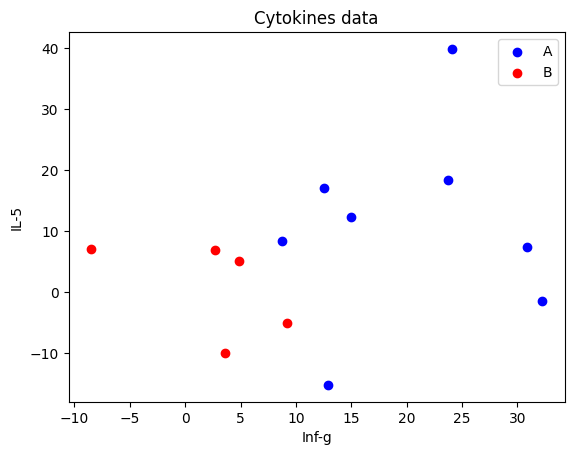

In [ ]:
plt.figure()
# Blue for A, Red for B
plt.scatter(Infg[A_idx], IL5[A_idx], color='blue', label='A', marker='o')
plt.scatter(Infg[B_idx], IL5[B_idx], color='red',  label='B', marker='o')
plt.xlabel("Inf-g")
plt.ylabel("IL-5")
plt.legend()
plt.title("Cytokines data")
plt.show()


Since it 's more clear that the group A has an high value of Ing-g instead for IL-5 it's not clear the distribution of the two groups we only consider Inf-g.

In [ ]:
# Shapiro test for seeing if the two groups of data A and B can come from the normal distribution
stat_A, pval_A = shapiro(Infg[A_idx])
stat_B, pval_B = shapiro(Infg[B_idx])
print("Shapiro test group A:", stat_A, pval_A)
print("Shapiro test group B:", stat_B, pval_B)

# Bartlett test for equality of variance to see if it's more appropiate LDA or QDA (different variance for each class)
bart_stat, bart_pval = bartlett(Infg[A_idx], Infg[B_idx])
print("Bartlett test: statistic =", bart_stat, "p-value =", bart_pval)

Shapiro test group A: 0.9068374410530939 0.3323301123037127
Shapiro test group B: 0.8754737847978038 0.28930121867682324
Bartlett test: statistic = 0.39982188279368674 p-value = 0.5271812583306359


SHAPIRO checks whether the data for each group follows a normal distribution. The p-values for both groups (A and B) are greater than 0.05, which suggests that the assumption of normality holds for both groups.

The Bartlett test checks whether the variances of the two groups are equal.  This result is important for LDA, as it assumes equal variance across groups. Since the Bartlett test shows that there is no significant difference in the variances, this supports the assumption for LDA.

the pvalue for The Barlett test in this case = 0.5 (strong proof in favor of EQUAL VARIANCE of the classes => LDA)

### Manual implementation of LDA

In [ ]:
nA = len(A_idx) #num points of class A
nB = len(B_idx) #                    B

n  = nA + nB #tot point

#estimate of the prior probabilities: num_obs_in_class_i / num_obs for i = 1,2,...,#num_classes

PA = nA / n #prior (PI) prob of belonging to cluster A prior P ( y = class_i)
PB = nB / n

#each class is assumed to be a normal distribution, so we compute the mean for each class
MA = np.mean(Infg[A_idx])
MB = np.mean(Infg[B_idx])

SA = np.var(Infg[A_idx], ddof=1)
SB = np.var(Infg[B_idx], ddof=1)

# Pooled variance estimate to have the unique variance of the two classes
S  = ((nA - 1) * SA + (nB - 1) * SB) / (n - 2)

print(f"Means: M_A={MA:.3f}, M_B={MB:.3f}")
print(f"Pooled var: S={S:.3f}")
print(f"Group prior probabilities: P(A)={PA}, P(B)={PB}")

Means: M_A=19.997, M_B=2.357
Pooled var: S=66.037
Group prior probabilities: P(A)=0.6153846153846154, P(B)=0.38461538461538464


In [ ]:
help(norm)

Help on norm_gen in module scipy.stats._continuous_distns:

<scipy.stats._continuous_distns.norm_gen object>
    A normal continuous random variable.
    
    The location (``loc``) keyword specifies the mean.
    The scale (``scale``) keyword specifies the standard deviation.
    
    As an instance of the `rv_continuous` class, `norm` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    rvs(loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, loc=0, scale=1)
        Probability density function.
    logpdf(x, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, loc=0, scale=1)
        Cumulative distribution function.
    logcdf(x, loc=0, scale=1)
        Log of the cumulative distribution function.
    sf(x, loc=0, scale=1)
        Survival function  (also defined as ``1 - cdf``, but `sf

Pooled Variance Estimate: Since LDA assumes that the two classes share the same variance, you’ll need to calculate the pooled variance. This is a weighted average of the variances of the two classes, using the number of samples in each class.

$$ P(y_i|X) = \frac{P(X|y_i)P(y_i)}{P(X)} = \frac{P(X|y_i)P(y_i)}{\sum_{j}P(X|y_j)P(y_j)}$$

P(y_i) is the prior

P(X|y_i) is the probability of the data X to belong to the class i (assumed to be gaussian with mean i and variance i)

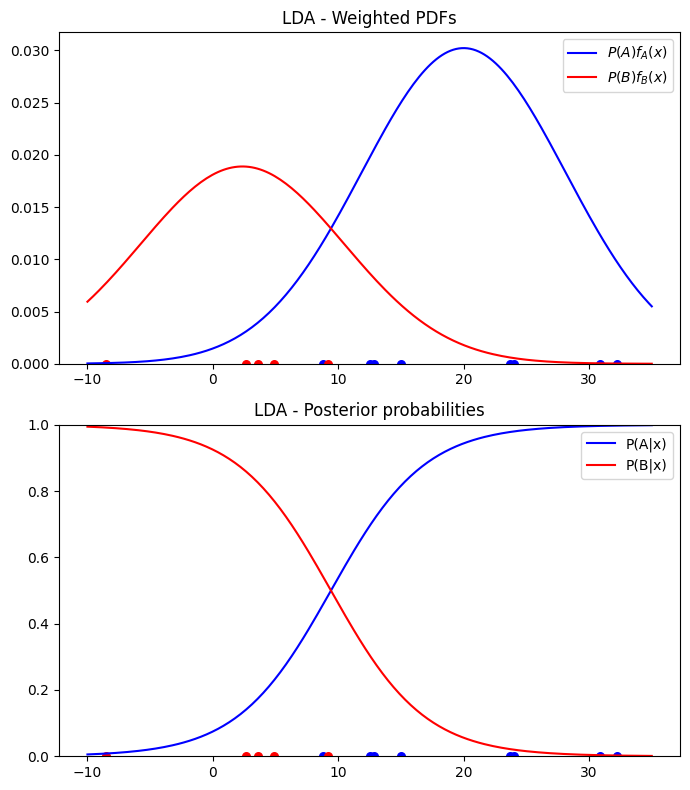

In [ ]:
xgrid = np.linspace(-10, 35, 200)

#LDA equale covariance matrix S

#per-class distribution of the features P_k(x | u_k, S)
# pdf for group A
pdfA = norm.pdf(xgrid, loc=MA, scale=np.sqrt(S))
# pdf for group B
pdfB = norm.pdf(xgrid, loc=MB, scale=np.sqrt(S))

plt.figure(figsize=(7,8))

# Top plot: PA * fA(x) and PB * fB(x)
plt.subplot(2,1,1)
#plotting P(X) marginal
plt.plot(xgrid, PA*pdfA, color='blue', label=r'$P(A)f_A(x)$') #i am plotting just the numerator
plt.plot(xgrid, PB*pdfB, color='red',  label=r'$P(B)f_B(x)$')
plt.scatter(Infg[A_idx], np.zeros(nA), color='blue', s=30)
plt.scatter(Infg[B_idx], np.zeros(nB), color='red',  s=30)
plt.ylim(0, None)
plt.title("LDA - Weighted PDFs")
plt.legend()

# Bottom plot: Posterior probabilities (scaled by the marginal):
postA = PA*pdfA / (PA*pdfA + PB*pdfB) #plotting all the formula  P(X|A)P(A) / P(X)
postB = PB*pdfB / (PA*pdfA + PB*pdfB) #  P(X|B)P(B) / P(X)

plt.subplot(2,1,2)
plt.plot(xgrid, postA, color='blue', label='P(A|x)')
plt.plot(xgrid, postB, color='red',  label='P(B|x)')
plt.scatter(Infg[A_idx], np.zeros(nA), color='blue', s=30)
plt.scatter(Infg[B_idx], np.zeros(nB), color='red',  s=30)
plt.ylim(0,1)
plt.title("LDA - Posterior probabilities")
plt.legend()
plt.tight_layout()
plt.show()


There is a point x = 10 where there is a THRESHOLD  where if a point is > threshold we are in A (higheer prob), instaed if point < THre we are in B (higher prob )

### LDA via scikit-learn

Fase di addestramento (fit): LDA stima i parametri della distribuzione normale per ogni classe. In particolare:

Calcola la media di ogni classe.

Calcola la varianza (o la matrice di covarianza) per ogni classe(QDA) o una varianza comune, nel caso di LDA con classi che hanno la stessa varianza.

Fase di predizione (predict) : Quando usi il metodo predict_proba(), scikit-learn calcola la posterior probability per ciascuna classe, che è una probabilità normalizzata (compresa tra 0 e 1). In altre parole, scikit-learn calcola le probabilità di appartenenza di un dato xx a ciascuna classe, normalizzando le densità di probabilità (calcolate dalle distribuzioni normali) tramite il teorema di Bayes. L'oggetto xx viene attribuito alla classe con l'indice  di probabilita massima .

Posterior at x=0: [0.07476761 0.92523239]
Class assigned at x=0: ['B']


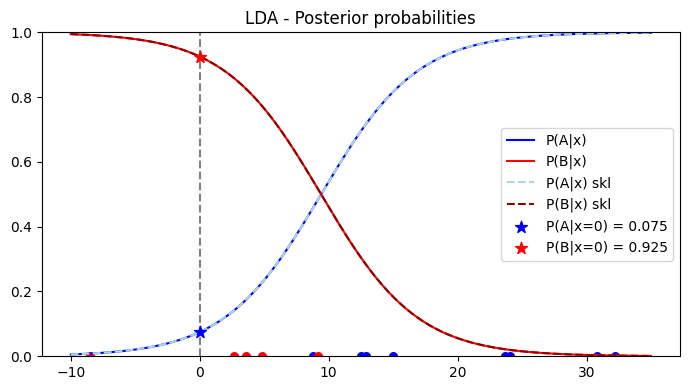

In [ ]:
X = Infg.reshape(-1, 1) #we have 1d data so we add the reshape
y = groups #labels

lda = LinearDiscriminantAnalysis() #oggetto LDA
lda.fit(X, y) #calculates the prior for each class, mean of each class, unique cov matrix, per class distribiution of features and the posterior

# Posterior probability for x=0:
#use the function predict to predict the outcome of a new obs as argmax k (Posterior(k)) = P(y=k|X=x) = argmax k (per_class_k * prior_k / marginal)
x0_val = 0.0
posterior0 = lda.predict_proba([[x0_val]])[0] #computes the posterior probabilities of the classes for x = 0
postA_x0, postB_x0 = posterior0  # two classes (A, B)
print("Posterior at x=0:", posterior0)
print("Class assigned at x=0:", lda.predict([[x0_val]]))

# Posterior for a grid of x
xgrid = np.linspace(-10, 35, 200).reshape(-1, 1)
post_grid = lda.predict_proba(xgrid)  # columns: prob of A, prob of B
postA_skl = post_grid[:,0]
postB_skl = post_grid[:,1]

plt.figure(figsize=(7,4))
plt.plot(xgrid, postA, color='blue', label='P(A|x)')
plt.plot(xgrid, postB, color='red',  label='P(B|x)')
plt.plot(xgrid, postA_skl, '--', color='lightblue', label='P(A|x) skl')
plt.plot(xgrid, postB_skl, '--', color='darkred',  label='P(B|x) skl')
plt.scatter(Infg[A_idx], np.zeros(nA), color='blue', s=30)
plt.scatter(Infg[B_idx], np.zeros(nB), color='red',  s=30)
# Highlight the value at x=0:
plt.axvline(x=x0_val, color='gray', linestyle='--')
# 2. Markers for the two posterior values at x=0
plt.scatter([x0_val], [postA_x0], s=80, color='blue',  marker='*', zorder=5,
            label='P(A|x=0) = {:.3f}'.format(postA_x0))
plt.scatter([x0_val], [postB_x0], s=80, color='red',   marker='*', zorder=5,
            label='P(B|x=0) = {:.3f}'.format(postB_x0))
plt.ylim(0,1)
plt.title("LDA - Posterior probabilities")
plt.legend()
plt.tight_layout()
plt.show()

Explicitly set the priors

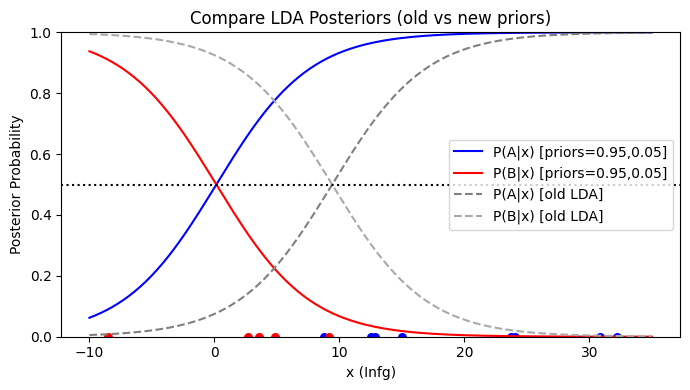

In [ ]:
lda_1 = LinearDiscriminantAnalysis(priors=[0.95, 0.05]) #setting the prob of the prior Explictly instead of the frequentistic estimate
lda_1.fit(X, y)

# Posterior on the same grid:
post_grid_1 = lda_1.predict_proba(xgrid)
postA_1 = post_grid_1[:, 0]
postB_1 = post_grid_1[:, 1]

plt.figure(figsize=(7, 4))

plt.plot(xgrid, postA_1, color='blue', label='P(A|x) [priors=0.95,0.05]')
plt.plot(xgrid, postB_1, color='red',  label='P(B|x) [priors=0.95,0.05]')

plt.plot(xgrid, postA_skl, '--', color='gray', label='P(A|x) [old LDA]')
plt.plot(xgrid, postB_skl, '--', color='darkgray', label='P(B|x) [old LDA]')

# Add horizontal line at 0.5
plt.axhline(y=0.5, color='black', linestyle=':')

# Add the points on x-axis for groups A and B
plt.scatter(Infg[A_idx], np.zeros(len(A_idx)), color='blue',  s=30)
plt.scatter(Infg[B_idx], np.zeros(len(B_idx)), color='red',   s=30)

plt.ylim(0, 1)
plt.xlabel("x (Infg)")
plt.ylabel("Posterior Probability")
plt.title("Compare LDA Posteriors (old vs new priors)")
plt.legend()
plt.tight_layout()
plt.show()

## Multivariate

### Iris

Considering only the first two variables of the iris datasets (Sepal Length and Sepal Width)

p = 2 # num variables (FEATURES)

g = 3 # num groups

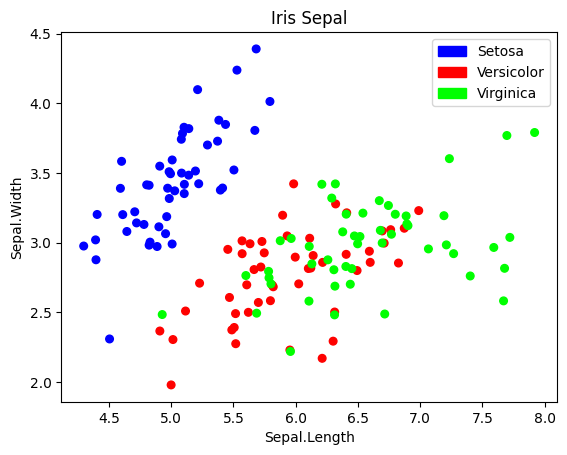

In [ ]:
from sklearn.datasets import load_iris
import matplotlib.patches as mpatches

iris_data = load_iris()
X_iris = iris_data.data[:, :2]  # only Sepal.Length, Sepal.Width
y_iris = iris_data.target       # 0, 1, 2 for setosa, versicolor, virginica
species_names = iris_data.target_names

# We'll add small jitter
rng = np.random.RandomState(1)
X_iris = X_iris + rng.normal(scale=0.025, size=X_iris.shape)

plt.figure()
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris, cmap='brg', s=30)

handles = [
    mpatches.Patch(color=plt.get_cmap("brg",3)(0), label='Setosa'),
    mpatches.Patch(color=plt.get_cmap("brg",3)(1), label='Versicolor'),
    mpatches.Patch(color=plt.get_cmap("brg",3)(2), label='Virginica')
]
plt.legend(handles=handles, loc='upper right')

plt.title("Iris Sepal")
plt.xlabel("Sepal.Length")
plt.ylabel("Sepal.Width")
plt.show()

Each row in lda_iris.coef_ corresponds to a linear discriminant function, which takes the form:
LDk(X)=wk1X1+wk2X2+ck
LDk​(X)=wk1​X1​+wk2​X2​+ck​

In [ ]:
# TODO: Fit LDA
lda_iris = LinearDiscriminantAnalysis()
lda_iris.fit(X_iris, y_iris)

#linear_boundary_class_k = w_k ^ T x + c_k
print("Coefficients of linear discriminants:\n", lda_iris.coef_) # wk1,wk2 for each k=1,2,3 (ho due features x1,x2 )
print("Intercepts:\n", lda_iris.intercept_) #ck for each k=1,2,3

#in totale avrò: g (num_tot_classi) * p (num_covariates) coefficienti [2 per ogni classe]
#                g intercette                                         [1 per ogni classe]

# Estrai i coefficienti (pesi delle rette) e gli intercepts
coefficients = lda_iris.coef_
intercepts = lda_iris.intercept_

Coefficients of linear discriminants:
 [[-5.94780454  7.87961702]
 [ 1.72106802 -3.82726215]
 [ 4.22673652 -4.05235487]]
Intercepts:
 [  5.63227073  -0.09185336 -15.14199104]


In [ ]:
# TODO: compute the output and the confusion matrix
y_pred = lda_iris.predict(X_iris)
conf_mat = confusion_matrix(y_iris, y_pred) #to measure how many points are assigned correctly (true labels vs assigment of my model).
print(conf_mat)

[[49  1  0]
 [ 0 35 15]
 [ 0 15 35]]


In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1])

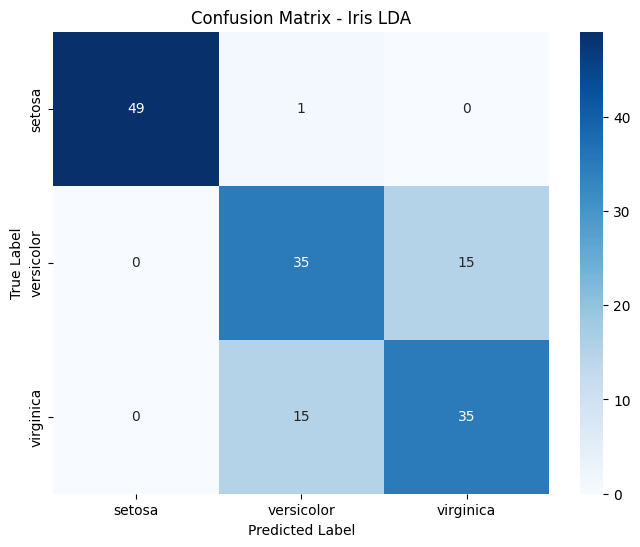

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=species_names, yticklabels=species_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Iris LDA")
plt.show()


In [ ]:
# APER (apparent error rate - proportion of misclassified samples)
# NB: this formula is correct if the proportions are estimated via empirical frequencies of prior prob
# Otherwise it is sum of P(error|group g) * P(group g) = sum{ # errors_for_group_g * prior_prob[g]}
n_samples = len(y_iris)
misclassified = (y_pred != y_iris).sum()
APER = misclassified / n_samples
print("APER =", APER)

APER = 0.20666666666666667


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_iris, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7933333333333333


Let's plot the decision boundary identified by LDA

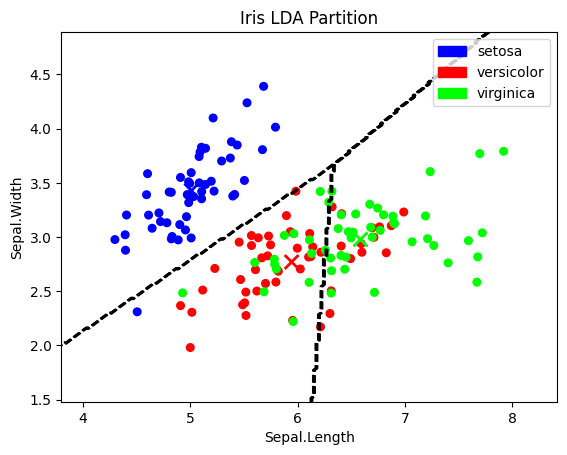

In [ ]:
def plot_lda_partition(model, X, y, class_labels=None, title="LDA Partition"):
  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
  grid_points = np.c_[xx.ravel(), yy.ravel()]

  unique_classes = np.unique(y)
  n_classes = len(unique_classes)
  cmap = plt.get_cmap("brg", n_classes)

  class_pred = model.predict(grid_points)

  plt.figure()
  plt.scatter(X[:,0], X[:,1], c=y, cmap='brg', s=30)
  plt.title("Iris LDA Partition")
  # Now let's draw boundaries where the predicted class changes:
  class_pred_matrix = class_pred.reshape(xx.shape)
  # We'll plot the contour lines between classes:
  # e.g., any place that transitions from class i to j is a boundary.
  plt.contour(xx, yy, class_pred_matrix,
              colors='k', linestyles='--')

  # Mark class means (model.means_ shape: [n_classes, n_features])
  means = model.means_
  plt.scatter(means[:,0], means[:,1], marker='x',
              c=range(len(means)), cmap='brg', s=100, linewidths=2)

  if class_labels is None:
      class_labels = [f"Class {cls}" for cls in unique_classes]  # Default labels if not provided

  handles = [mpatches.Patch(color=cmap(i), label=class_labels[i]) for i in range(n_classes)]
  plt.legend(handles=handles, loc='upper right')

  plt.xlabel("Sepal.Length")
  plt.ylabel("Sepal.Width")
  plt.show()

plot_lda_partition(lda_iris, X_iris, y_iris, class_labels=species_names, title="Iris LDA Partition")


# Quadratic Discriminant Analysis

## Iris

In [ ]:
### TODO: fit a Quadratic Discriminant Analysis model from scikit learn, compute the APER and the confusion matrix
#Each class has its own mean (as in LDA) and its OWN variance (different from LDA)
qda_iris = QuadraticDiscriminantAnalysis()
qda_iris.fit(X_iris, y_iris)

y_pred = qda_iris.predict(X_iris)
conf_mat = confusion_matrix(y_iris, y_pred)
print(conf_mat)
n_samples = len(y_iris)
misclassified = (y_pred != y_iris).sum()
APER = misclassified / n_samples
print("APER =", APER)

[[49  1  0]
 [ 0 37 13]
 [ 0 16 34]]
APER = 0.2


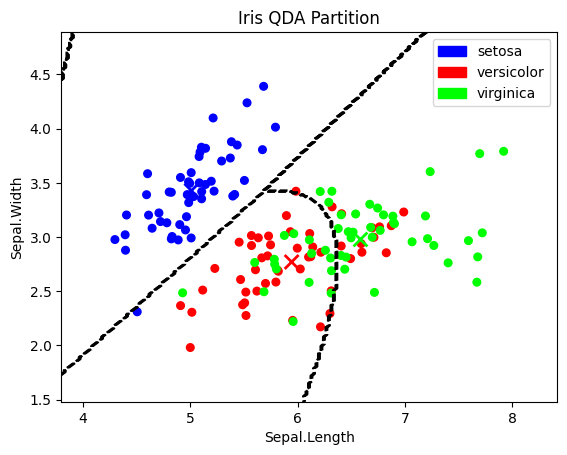

In [ ]:
def plot_qda_partition(model, X, y, class_labels=None, title="QDA Partition", cmap=None,xtitle="Sepal.Length",ytitle="Sepal.Width"):
    if cmap is None:
        cmap = plt.get_cmap("brg", 3)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    class_pred = model.predict(grid_points)
    if isinstance(class_pred[0], str):
      class_pred = np.array([np.where(class_labels == i) for i in class_pred])
    class_pred_matrix = class_pred.reshape(xx.shape)

    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    cmap = plt.get_cmap("brg", n_classes)

    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, s=30)
    plt.title(title)
    plt.contour(xx, yy, class_pred_matrix,
                colors='k', linestyles='--')

    # Mark class means
    means = model.means_
    plt.scatter(means[:,0], means[:,1], marker='x',
                c=range(len(means)), cmap=cmap, s=100, linewidths=2)

    if class_labels is None:
        class_labels = [f"Class {cls}" for cls in unique_classes]  # Default labels if not provided

    handles = [mpatches.Patch(color=cmap(i), label=class_labels[i]) for i in range(n_classes)]
    plt.legend(handles=handles, loc='upper right')

    plt.xlabel("Sepal.Length")
    plt.ylabel("Sepal.Width")
    plt.show()

plot_qda_partition(qda_iris, X_iris, y_iris, class_labels=species_names, title="Iris QDA Partition")


## Cost-sensitive classification (Banknotes example)

The vending machines of the Exxon fuel contain optical detectors able
to measure the size of the banknotes inserted. Knowing that 0.1% of the
10\$ banknotes in circulation are counterfeit, Exxon would like to implement a
software to identify false 10$ banknotes, as to minimize the economic losses.
Assuming that:
  - both the populations of real and false banknotes follow a normal distribution (with different mean and covariance matrices) => QDA;
  
  - accepting a false banknote leads to an economic loss of 10$;

  - rejecting a true banknote brings a economic loss quantifiable in 5 cents;

 satisfy the following requests of the Exxon:

 a) build an appropriate classifier, estimating the unknown parameters starting from the two datasets moneytrue.txt and moneyfalse.txt, containing data about 100 true banknotes and 100 counterfeit banknotes (in mm). Qualitatively show the two classification regions in a graph;

 b) calculate the APER of the classifier and, based on the APER, estimate the expected economic damage of the classifier;

 c) what is the estimated probability that the first 10$ banknote inserted in the machine is rejected?

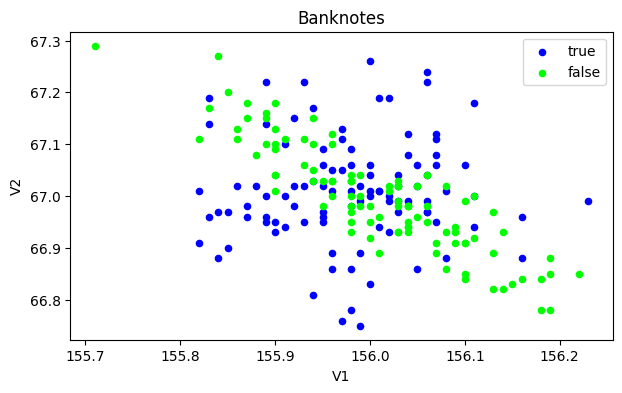

In [ ]:
true_df  = pd.read_table("moneytrue.txt", sep=" ")   # columns e.g. V1, V2
false_df = pd.read_table("moneyfalse.txt", sep=" ")  # columns e.g. V1, V2

true_data  = true_df[["V1","V2"]].values
false_data = false_df[["V1","V2"]].values

banknotes = np.vstack([true_data, false_data])
vf = np.array(["true"]*len(true_data) + ["false"]*len(false_data), dtype=object)

plt.figure(figsize=(7,4))
plt.scatter(true_data[:,0],  true_data[:,1], color=(0.0, 0.0, 1.0, 1.0),  label='true', s=20)
plt.scatter(false_data[:,0], false_data[:,1], color=(0.0, 1.0, 0.0, 1.0), label='false', s=20)
plt.xlabel("V1")
plt.ylabel("V2")
plt.title("Banknotes")
plt.legend()
plt.show()

Priori probabilities determine the importance of a class. If misclassifying False as True is very costly, we need to increase the prior probability of False:

$$
\pi_{False}' = \frac{c_{TF}\cdot\pi_{False}}{c_{TF}\cdot\pi_{False} + c_{FT}\cdot\pi_{True}}
$$

 a) build an appropriate classifier, estimating the unknown parameters starting from the two datasets moneytrue.txt and moneyfalse.txt, containing data about 100 true banknotes and 100 counterfeit banknotes (in mm). Qualitatively show the two classification regions in a graph;

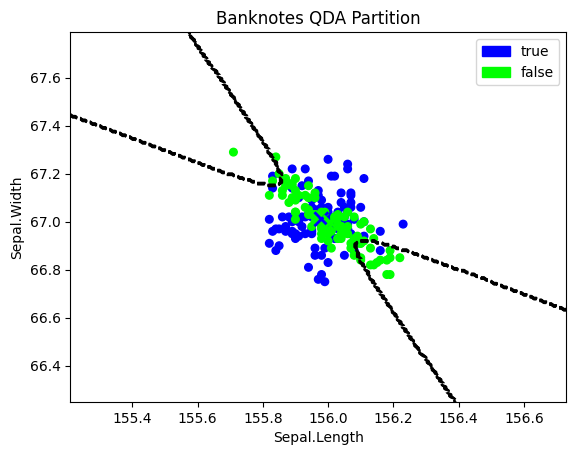

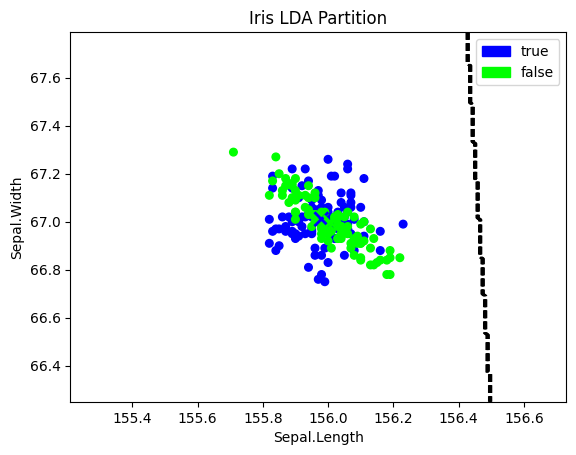

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

c_tf = 10    # cost of accepting a false banknote (cost of  predicting true $10 but in reality it's a FALSE one)
c_ft = 0.05  # cost of rejecting a true banknote (cost of predicting false $10 but it was a TRUE one)
pf   = 0.001 #prob that a banknote is false
pt   = 1 - pf

# Adjusted priors: (NOT a pure frequentistic estimate:  (n_true/n; n_false/n) )
num = c_tf*pf + c_ft*pt # normalization factor to keep them sum to 1
p_true_c = pt*c_ft / num
p_false_c = pf*c_tf / num
prior_c = [p_true_c, p_false_c] #adjusted PRIORS of belonging to TRUE/FALSE

desired_order = ["true", "false"]  # the order MUST be consisted with the order of the priors!
y_encoded = np.array([desired_order.index(label) for label in vf])

qda_bank = QuadraticDiscriminantAnalysis(priors=prior_c) #give as a parameter the new prior (override)
qda_bank.fit(banknotes, y_encoded)

lda_bank = LinearDiscriminantAnalysis(priors=prior_c)
lda_bank.fit(banknotes, y_encoded)


plot_qda_partition(qda_bank, banknotes, y_encoded, class_labels=desired_order, title="Banknotes QDA Partition")
plot_lda_partition(lda_bank, banknotes, y_encoded, class_labels=desired_order, title="Banknotes LDA Partition")


b) calculate the APER of the classifier and, based on the APER, estimate the expected economic damage of the classifier;

In [ ]:
y_pred = qda_bank.predict(banknotes) #the LDA separation boundaries are really poor so we are using QDA.

# Compute confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

tp, fn, fp, tn = conf_matrix.ravel()  # Extract False Positives (FP) and False Negatives (FN)

## NB: be aware that here we have the TRUE as the first class, but it is more common to have viceversa

# APER Calculation using extracted FP and FN values
# APER = P(true) * P(misclassified | true) + P(false) * P(misclassified | false)
aper = p_true_c * (fn / (tp + fn)) + p_false_c * (fp / (fp + tn))

print("\nApparent Error Rate (APER): {:.4f}".format(aper))

Confusion Matrix:
[[98  2]
 [80 20]]

Apparent Error Rate (APER): 0.1501


c) what is the estimated probability that the first 10$ banknote inserted in the machine is rejected?

In [ ]:
# P[rejected] = P[rejected | true]P[true] + P[rejected | false]P[false]

(fn / (fn+ tp)) * pt + (tn / (tn + fp)) * pf

np.float64(0.02018)

# Fisher Discriminant Analysis

LDA can also be used to project the data into a lower dimensional space, which maximizes the SEPARABILITY between the classes

In [ ]:
from sklearn.metrics import confusion_matrix

X = X_iris
y = y_iris

# Apply Fisher's Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)  # Transform data into canonical coordinates X_lda (to maximizes the separability)

# Compute the confusion matrix for model performance
y_pred = lda.predict(X) #classificare i dati originali X
conf_matrix = confusion_matrix(y, y_pred)
APER = 1 - np.trace(conf_matrix) / np.sum(conf_matrix)

print("Misclassification Rate (APER):", APER)
print("Confusion Matrix:\n", conf_matrix)

Misclassification Rate (APER): 0.20666666666666667
Confusion Matrix:
 [[49  1  0]
 [ 0 35 15]
 [ 0 15 35]]


You’re applying Fisher's Linear Discriminant Analysis with n_components=2, so you are projecting your data from the original 2-dimensional space into a 2-dimensional(n_components=2) subspace that best maximizes class separability.

How to classify a new observation in [5.85, 2.90]?

In [ ]:
print("Shape of X_iris", X_iris.shape)
print("Shape of X_lda", X_lda.shape)

Shape of X_iris (150, 2)
Shape of X_lda (150, 2)


New observation classified as: versicolor


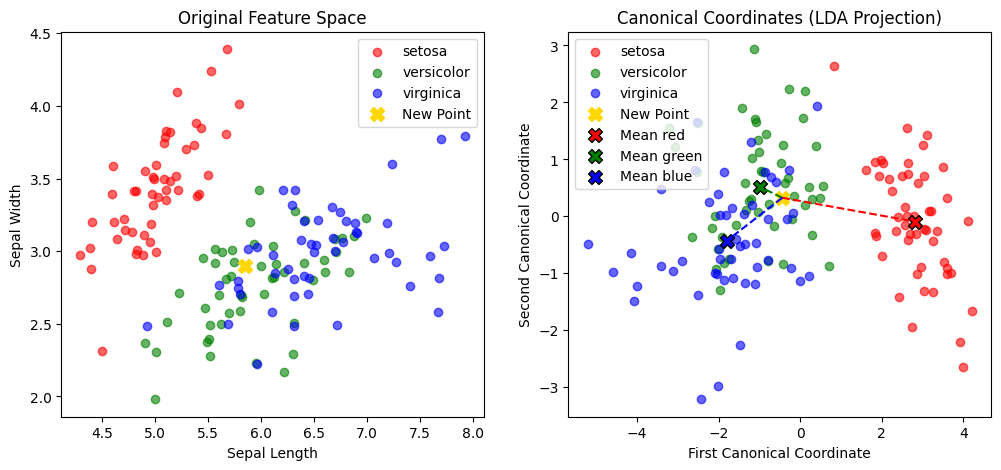

In [ ]:
x_new = np.array([[5.85, 2.90]])  # New observation
cc_new = lda.transform(x_new)  # Project into Fisher’s space
assigned_class = lda.predict(x_new) #predict in the original space, fit trains on X original
print("New observation classified as:", species_names[assigned_class[0]])

color_species = ['red', 'green', 'blue']

# Compute class means in LDA space
class_means_lda = lda.transform(lda.means_)  # Get means in LDA space

#assigne the new obs in LDA space to the closest centroid in X-LDA space.

# Plot LDA Results with Connection Lines to Class Centers
def plot_fisher_score_with_connections():
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Original Coordinate Space
    for i, color in zip(range(3), color_species):
        ax[0].scatter(X[y == i, 0], X[y == i, 1], c=color, label=species_names[i], alpha=0.6)

    ax[0].scatter(x_new[0, 0], x_new[0, 1], c='gold', marker='X', s=100, label="New Point")
    ax[0].set_xlabel("Sepal Length")
    ax[0].set_ylabel("Sepal Width")
    ax[0].set_title("Original Feature Space")
    ax[0].legend()

    # Canonical Coordinate Space (LDA Projection)
    for i, color in zip(range(3), color_species):
        ax[1].scatter(X_lda[y == i, 0], X_lda[y == i, 1], c=color, label=species_names[i], alpha=0.6)

    ax[1].scatter(cc_new[0, 0], cc_new[0, 1], c='gold', marker='X', s=100, label="New Point")

    # Connect new observation to class means
    for mean, color in zip(class_means_lda, color_species):
        ax[1].scatter(mean[0], mean[1], c=color, marker="X", s=100, edgecolors="black", label=f"Mean {color}")
        ax[1].plot([cc_new[0, 0], mean[0]], [cc_new[0, 1], mean[1]], color=color, linestyle="dashed")

    ax[1].set_xlabel("First Canonical Coordinate")
    ax[1].set_ylabel("Second Canonical Coordinate")
    ax[1].set_title("Canonical Coordinates (LDA Projection)")
    ax[1].legend()

    plt.show()

plot_fisher_score_with_connections()


# In the Fisher space, we can classify a new point by assigning it to the class whose mean (centroid) it is closest to.
In this case is the green oe.

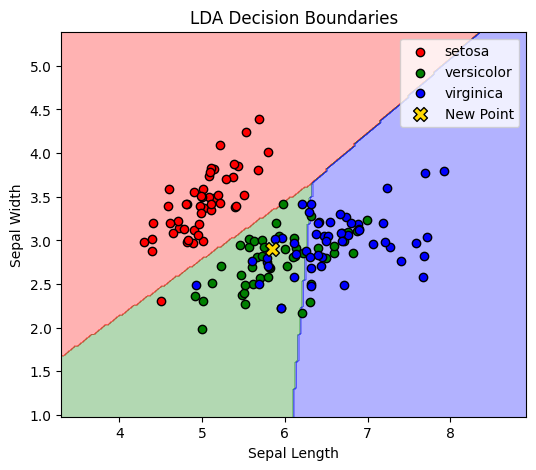

In [ ]:
from matplotlib.colors import ListedColormap

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                      np.linspace(y_min, y_max, 200))

# Predict on the grid
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(color_species))
for i, color in zip(range(3), color_species):
    plt.scatter(X[y == i, 0], X[y == i, 1], c=color, label=species_names[i], edgecolors='k')

plt.scatter(x_new[0, 0], x_new[0, 1], c='gold', marker='X', s=100, label="New Point", edgecolors='black')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("LDA Decision Boundaries")
plt.legend()
plt.show()

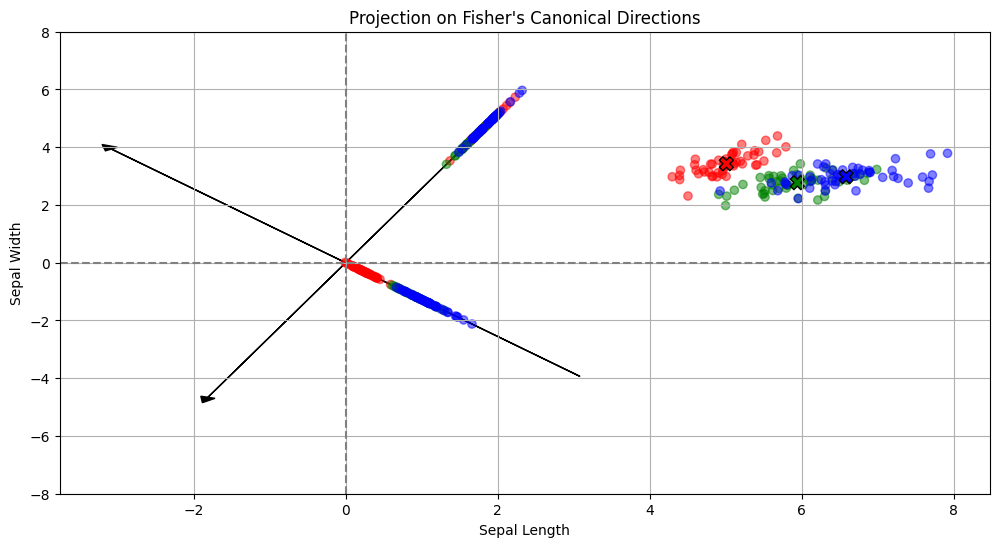

In [ ]:
X_lda = lda.fit_transform(X_iris, y_iris)  # Canonical coordinates of data

# Fisher directions (discriminant vectors)
a1, a2 = lda.scalings_[:, 0], lda.scalings_[:, 1]

# Normalize Fisher directions for visualization
a1 /= np.linalg.norm(a1)
a2 /= np.linalg.norm(a2)

# Compute projections onto Fisher directions in the original space
proj_a1 = np.outer(X_iris @ a1, a1) / np.sum(a1 ** 2)
proj_a2 = np.outer(X_iris @ a2, a2) / np.sum(a2 ** 2)

class_means = lda.means_  # Means in original space

# Plot: Projection on Canonical Directions (Original Space)**
plt.figure(figsize=(12, 6))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=[color_species[val] for val in y], alpha=0.5, label="Data")
plt.scatter(class_means[:, 0], class_means[:, 1], c=color_species, marker="X", s=100, edgecolors="black", label="Class Means")

# Scale factor for better visibility
t = 5

# Arrows for Fisher directions
plt.arrow(-t * a1[0], -t * a1[1], 2 * t * a1[0], 2 * t * a1[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="a1 (First Canonical Direction)")
plt.arrow(-t * a2[0], -t * a2[1], 2 * t * a2[0], 2 * t * a2[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="a2 (Second Canonical Direction)")

# Add dashed lines for original axes
plt.axhline(0, color='gray', linestyle='dashed')
plt.axvline(0, color='gray', linestyle='dashed')

# Projection of points onto Fisher's directions
plt.scatter(proj_a1[:, 0], proj_a1[:, 1], c=[color_species[val] for val in y], alpha=0.5)
plt.scatter(proj_a2[:, 0], proj_a2[:, 1], c=[color_species[val] for val in y], alpha=0.5)

# Labels
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Projection on Fisher's Canonical Directions")
plt.grid(True)
plt.ylim(-8,8)
plt.show()

In [ ]:
# Compute the angle between a1 and a2
dot_product = np.dot(a1, a2)
angle_radians = np.arccos(dot_product)  # Angle in radians
angle_degrees = np.degrees(angle_radians)  # Convert to degrees

angle_degrees

np.float64(120.67238013494564)

Let's compare the projection on LDA axes with the one on PCA axes

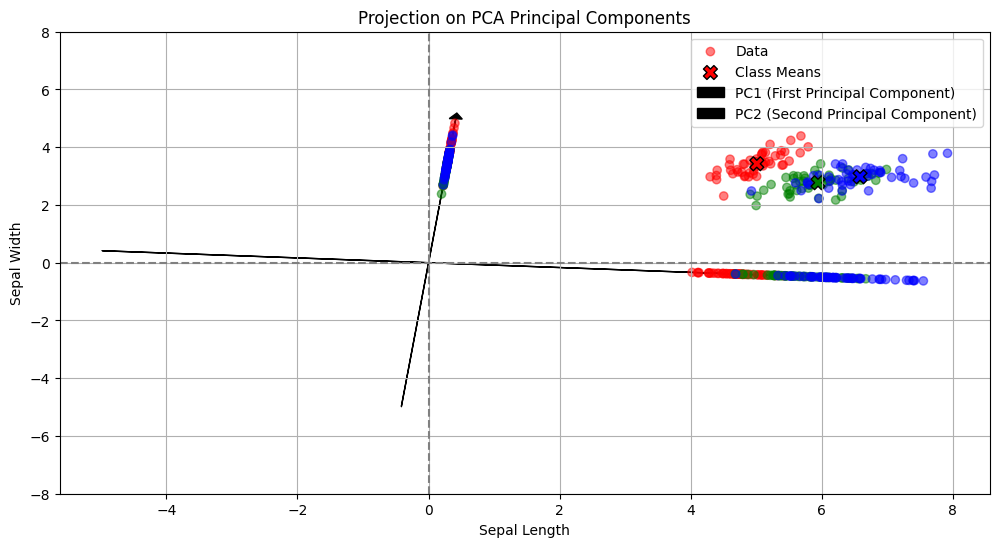

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_iris, y_iris, and color_species are already defined

# Perform PCA on the original data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_iris)  # PCA-transformed coordinates

pca1, pca2 = pca.components_

# Normalize PCA directions for visualization
pca1 /= np.linalg.norm(pca1)
pca2 /= np.linalg.norm(pca2)

# Compute projections onto PCA directions in the original space
proj_pca1 = np.outer(X_iris @ pca1, pca1) / np.sum(pca1 ** 2)
proj_pca2 = np.outer(X_iris @ pca2, pca2) / np.sum(pca2 ** 2)

# Compute class means in original space
class_means_pca = np.array([X_iris[y_iris == i].mean(axis=0) for i in range(3)])

# Plot: Projection on PCA Directions (Original Space)
plt.figure(figsize=(12, 6))
colors = [color_species[i] for i in y_iris]  # Define colors for data points

plt.scatter(X_iris[:, 0], X_iris[:, 1], c=colors, alpha=0.5, label="Data")
plt.scatter(class_means_pca[:, 0], class_means_pca[:, 1], c=color_species, marker="X", s=100, edgecolors="black", label="Class Means")

# Scale factor for better visibility
t = 5

# Arrows for PCA directions
plt.arrow(-t * pca1[0], -t * pca1[1], 2 * t * pca1[0], 2 * t * pca1[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="PC1 (First Principal Component)")
plt.arrow(-t * pca2[0], -t * pca2[1], 2 * t * pca2[0], 2 * t * pca2[1], head_width=0.2, head_length=0.2, fc='black', ec='black', label="PC2 (Second Principal Component)")

# Add dashed lines for original axes
plt.axhline(0, color='gray', linestyle='dashed')
plt.axvline(0, color='gray', linestyle='dashed')

# Projection of points onto PCA directions (using colors list)
plt.scatter(proj_pca1[:, 0], proj_pca1[:, 1], c=colors, alpha=0.5)
plt.scatter(proj_pca2[:, 0], proj_pca2[:, 1], c=colors, alpha=0.5)

# Labels
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Projection on PCA Principal Components")
plt.grid(True)
plt.ylim(-8, 8)
plt.legend() # Add legend to the plot
plt.show()

In [ ]:
# Compute the angle between pca1 and pca2
dot_product = np.dot(pca1, pca2)
angle_radians = np.arccos(dot_product)  # Angle in radians
angle_degrees = np.degrees(angle_radians)  # Convert to degrees

angle_degrees

np.float64(90.0)

# K-Neareast Neighbour

## Iris

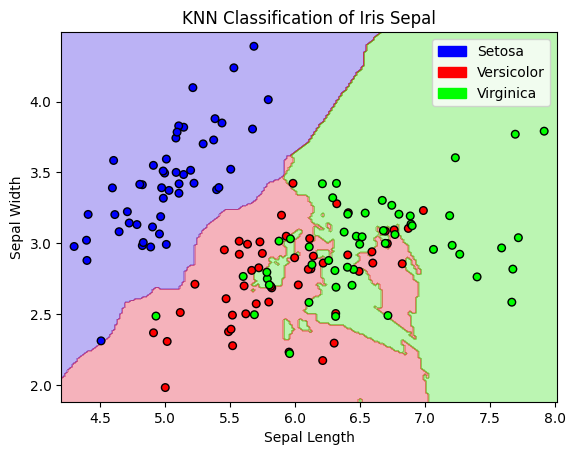

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Using 5 neighbors
knn.fit(X_iris, y_iris)

# Create a mesh grid for decision boundary
x_min, x_max = X_iris[:, 0].min() - 0.1, X_iris[:, 0].max() + 0.1
y_min, y_max = X_iris[:, 1].min() - 0.1, X_iris[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict the class for each point in the grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3, cmap='brg')

# Plot the data points
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='brg', edgecolor='k', s=30)

# Legend for species
handles = [
    mpatches.Patch(color=plt.get_cmap("brg", 3)(0), label='Setosa'),
    mpatches.Patch(color=plt.get_cmap("brg", 3)(1), label='Versicolor'),
    mpatches.Patch(color=plt.get_cmap("brg", 3)(2), label='Virginica')
]
plt.legend(handles=handles, loc='upper right')

# Labels and title
plt.title("KNN Classification of Iris Sepal")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()


In [ ]:
y_pred = knn.predict(X_iris)

conf_matrix = confusion_matrix(y_iris, y_pred)

# Compute APER (Apparent Error Rate)
aper = 1 - accuracy_score(y_iris, y_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nApparent Error Rate (APER): {:.4f}".format(aper))


Confusion Matrix:
[[50  0  0]
 [ 0 37 13]
 [ 0 11 39]]

Apparent Error Rate (APER): 0.1600


Training: memorizza i dati.

Predizione: fa tutti i calcoli (distanze, voti, ecc).
Per fare una predizione con il k-NN:

    Calcola la distanza tra il nuovo punto e tutti i punti nel dataset di training (di solito si usa la distanza euclidea, ma può variare).

    Ordina i punti del training in base alla distanza crescente.

    Prende i primi k punti più vicini (i “k vicini”).

    Guarda la classe di appartenenza di ciascuno di questi k punti.

    Conta le frequenze delle classi e assegna al nuovo punto la classe più frequente tra i vicini.

## Banknotes

In [ ]:
from collections import Counter

# Define cost-sensitive priors
c_tf = 10    # Cost of accepting a false banknote
c_ft = 0.05  # Cost of rejecting a true banknote
pf   = 0.001 # Prior probability of a false banknote
pt   = 1 - pf # Prior probability of a true banknote

# Compute adjusted priors
num = c_tf * pf + c_ft * pt  # Normalization factor
p_true_c = (pt * c_ft) / num
p_false_c = (pf * c_tf) / num
prior_c = [p_true_c, p_false_c]

# Ensure labels match the priors
desired_order = ["true", "false"]  # Order must be consistent with priors
banknotes = np.vstack([true_data, false_data])
vf = np.array(["true"]*len(true_data) + ["false"]*len(false_data), dtype=object)
y_encoded = np.array([desired_order.index(label) for label in vf])  # Encode labels


# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(banknotes, y_encoded)

# Retrieve neighbors for each test sample
distances, indices = knn.kneighbors(banknotes)

# Custom decision function that adjusts for priors
y_pred_adjusted = []
for i in range(len(banknotes)):
    neighbors = y_encoded[indices[i]]  # Get nearest neighbors' classes
    vote_counts = Counter(neighbors)  # Count occurrences of each class

    # Adjust votes based on priors
    weighted_votes = {cls: count * prior_c[cls] for cls, count in vote_counts.items()}

    # Assign the class with the highest weighted vote
    adjusted_prediction = max(weighted_votes, key=weighted_votes.get)
    y_pred_adjusted.append(adjusted_prediction)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred_adjusted)


# Print results
print("Confusion Matrix (With Adjusted Priors):")
print(conf_matrix)

Confusion Matrix (With Adjusted Priors):
[[100   0]
 [ 78  22]]


In [ ]:
#APER
# Compute confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred_adjusted)

# Extract values from confusion matrix
tp, fn, fp, tn = conf_matrix.ravel()

# Calculate APER
aper = (fn / (tp + fn)) * p_true_c + (fp / (fp + tn)) * p_false_c

# Print results
print("Confusion Matrix (With Adjusted Priors):")
print(conf_matrix)
print("\nApparent Error Rate (APER): {:.4f}".format(aper))

Confusion Matrix (With Adjusted Priors):
[[100   0]
 [ 78  22]]

Apparent Error Rate (APER): 0.1301


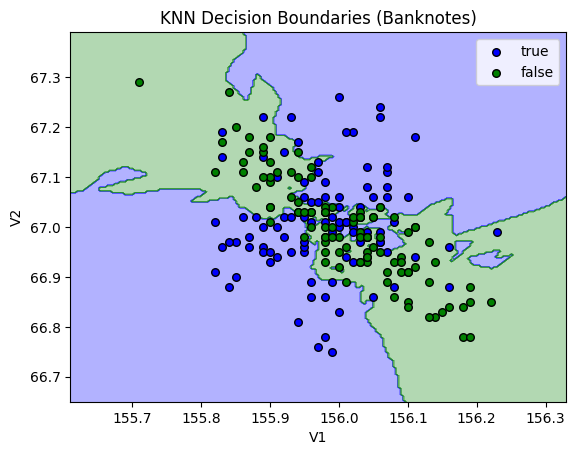

In [ ]:
# TODO: plot decision boundaries
from matplotlib.colors import ListedColormap

# Create mesh grid for plotting
x_min, x_max = banknotes[:, 0].min() - 0.1, banknotes[:, 0].max() + 0.1
y_min, y_max = banknotes[:, 1].min() - 0.1, banknotes[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on the grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create color map
cmap = ListedColormap(['blue', 'green'])  # Adjust colors if needed

# Plot decision boundaries
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

# Plot data points
plt.scatter(banknotes[y_encoded == 0, 0], banknotes[y_encoded == 0, 1],
            c='blue', label=desired_order[0], edgecolor='k', s=30)
plt.scatter(banknotes[y_encoded == 1, 0], banknotes[y_encoded == 1, 1],
            c='green', label=desired_order[1], edgecolor='k', s=30)

# Labels and title
plt.title("KNN Decision Boundaries (Banknotes)")
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend()
plt.show()